# **Introduction**

One of the most fascinating datasets that I've come across is the Ames Housing dataset. It was originally collated by Dr. Dean De Cock (Truman State Univ) for the undergraduate statistical methods course, and later became very popular through Kaggle.

For about 3000 houses sold in Ames City (Iowa, US) between 2006 and 2010, are given the following info: 
 * Location of the House
 * House Size and Area Measurements
 * Furnishing of the House
 * Subjective Evaluations of House
 * Immediate Context of Sale

Our objective is to predict and explain the Sale Price of the house based on its location, size, furnishing, quality, context etc.

References:
 * [Author's Introduction](https://tinyurl.com/ycfc58y8)
 * [Data Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)
 * [Data in Excel](https://tinyurl.com/ycbbw3h7)


In [436]:
PATH = '/content/drive/My Drive/Projects/Machine Learning/Real World Problems/Housing Prices/AmesHousing.xls'
import pandas as pd
df = pd.read_excel(PATH)
df.columns = [i.replace(' ', '') for i in df.columns]
print(df[['PID', 'SalePrice', 'Neighborhood', 'GrLivArea', 'YrSold', 'MoSold']].sample(frac = 1).head(10))

            PID  SalePrice Neighborhood  GrLivArea  YrSold  MoSold
662   535383060      59000      OldTown        599    2009       6
458   528180120     320000      NridgHt       1884    2009       5
1493  908128110     165400      Edwards       1656    2008       7
2104  906380120     203000      CollgCr       1274    2007       1
1044  527451400      89500       BrDale        987    2008       8
979   923228230      88000      MeadowV       1092    2009       8
2414  528218140     219210      Gilbert       1863    2006      11
2074  905376090     216000      Edwards       1325    2007       7
1127  528480160     205950      Somerst       1665    2008       5
70    528477080     254900      Somerst       1947    2010       5


# **Variable of Interest: Sale Price**

*plotDist* Function -> Plots Histogram with μ ± 3σ Bars

In [0]:
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
def plotDist(var):
    sns.distplot(df[var], hist=True, kde = False)
    μ, σ = df[var].mean(), df[var].std()
    plt.axvline(μ - 3 * σ, color='black', linestyle = '--')
    plt.axvline(μ + 3 * σ, color='black', linestyle = '--')
    plt.title(f'Distribution of {var}')
    plt.show()

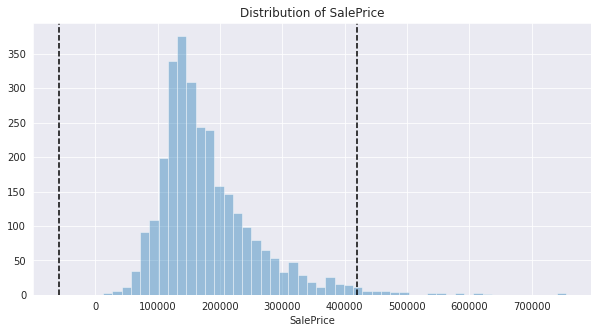

In [438]:
plotDist('SalePrice')

Two observations: 
1. A majority of houses are sold for less, a minority of houses are sold for a really, really high amount. Sale Price exhibits high left skew, and thus needs to be log-transformed. Once done, it appears nearly normal.
2. Post log-transformation, we remove outliers outside μ ± 3σ. These examples were aberrations that could mislead. 

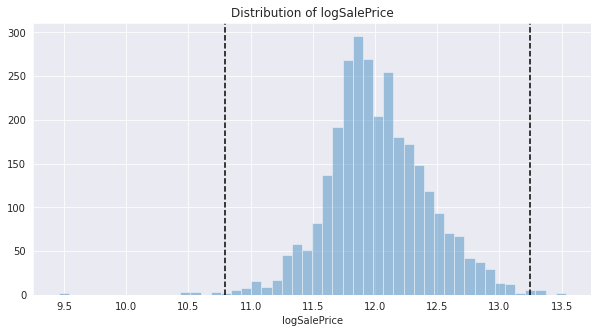

In [439]:
df['logSalePrice'] = np.log(df.SalePrice)
plotDist('logSalePrice')

* We remove outliers below and above these statistical thresholds. 
* Additionally, by the recommendation of the author we remove houses with "GrLivArea" greater than 4000. 

Old No of Examples: 2930
New No of Examples: 2898
Diff in Examples: 32


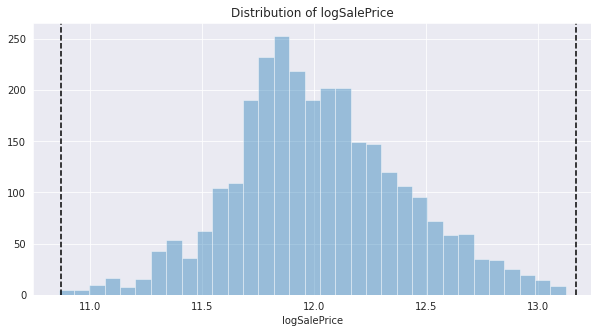

In [440]:
old_examples = df.shape[0]
df = df[(df.logSalePrice > μ - 3 * σ) & (df.logSalePrice < μ + 3 * σ) & (df.GrLivArea < 4000)]
new_examples = df.shape[0]
print('Old No of Examples:', old_examples)
print('New No of Examples:', new_examples)
print('Diff in Examples:', old_examples - new_examples)
plotDist('logSalePrice')

# **Factors behind Log Sale Price**

* **Location of the House:** Ordinal attributes telling us the Neighborhood, Postal ID, Zoning allocation.
* **Size of the House:** Continous attributes which capture Sq Feet Area of the Lot, Living Space, Basement, etc.
* **Contents of the House:** Mainly count vectors telling us the no. of rooms, furnished items, etc.
* **Subjective Evaluations:** Subjective Evaluations such as 'Overall Quality' of different aspects.  
* **Immediate Context of Sale:** The time of year, the mode of payment and relation between seller & buyer.
* **Variations in Demand:** As proxied by no. of sales conducted before, in the neighborhood. 



*CatPlot* Function -> Plots LogSalePrice Distributions across ordinal values, ordered.



In [0]:
def CatPlot(var, sortVar = 'logSalePrice'):
    my_order = df[['logSalePrice', var]].groupby(by=var).mean().sort_values(sortVar).index
    chart = sns.violinplot(x=var, y='logSalePrice', data=df, order=my_order)
    chart.axhline(y = df.logSalePrice.mean(), color='black', linewidth=2) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
    plt.title(f'Distribution of logSalePrice with {var}')
    plt.show()

*NNReg* Function -> Neural Net Regression between LogSalePrice and Selected Variables. Ensures numericals get standardized and ordinals get dummified. 

In [0]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from warnings import filterwarnings
filterwarnings('ignore')

def DataGen(var):
    global df
    print(df.columns)
    y = df.logSalePrice
    x = df[var].copy()
    for i in x.select_dtypes(exclude = 'object'):
        ε = 0.0000001
        x[i] = (x[i]-x[i].mean(axis = 0)+ε)/(x[i].std(axis = 0)+ε)
    for i in x.select_dtypes(include = 'object').columns:
        x = pd.concat([x, pd.get_dummies(x[i])], axis = 1)
        x = x.drop(i, axis = 1)
    return train_test_split(x, y, test_size = 0.3, random_state = 42)

def NNReg(var, alpha = 2, yhat_and_y = False):
    x_train, x_val, y_train, y_val = DataGen(var)

    N_h1, N_h2 = round(x_train.shape[1] * 1.5), round(x_train.shape[1] * 0.5)
    model = MLPRegressor(hidden_layer_sizes = (N_h1, N_h2), alpha = alpha, max_iter = 500, random_state = 42, verbose = False)
    model.fit(x_train, y_train)
    yhat = model.predict(x_train)
    print(f'Train R Square: {r2_score(y_train, yhat):0.3f}')
    print(f'Test R Square: {r2_score(y_val, model.predict(x_val)):0.3f}')

    if yhat_and_y == True: 
        plt.figure(figsize=(16, 6))
        plt.scatter(y_val, y_val, c = 'black',  marker='.', label = 'Actual Values vs Actual Values')
        plt.scatter(model.predict(x_val), y_val, c = 'red', marker='.', label = 'Actual Values vs Predicted Values')
        plt.title('Regression Model for logSalePrice')
        plt.ylabel('True Values')
        plt.xlabel('Predictions')
        plt.legend()
        plt.show()
    
    return model

# **Variation of Sale Price by Location** 


* Sale Price varies a lot by Neighborhood. 

* Residential & Commerical [Maps](https://www.cityofames.org/government/departments-divisions-a-h/city-assessor/maps)

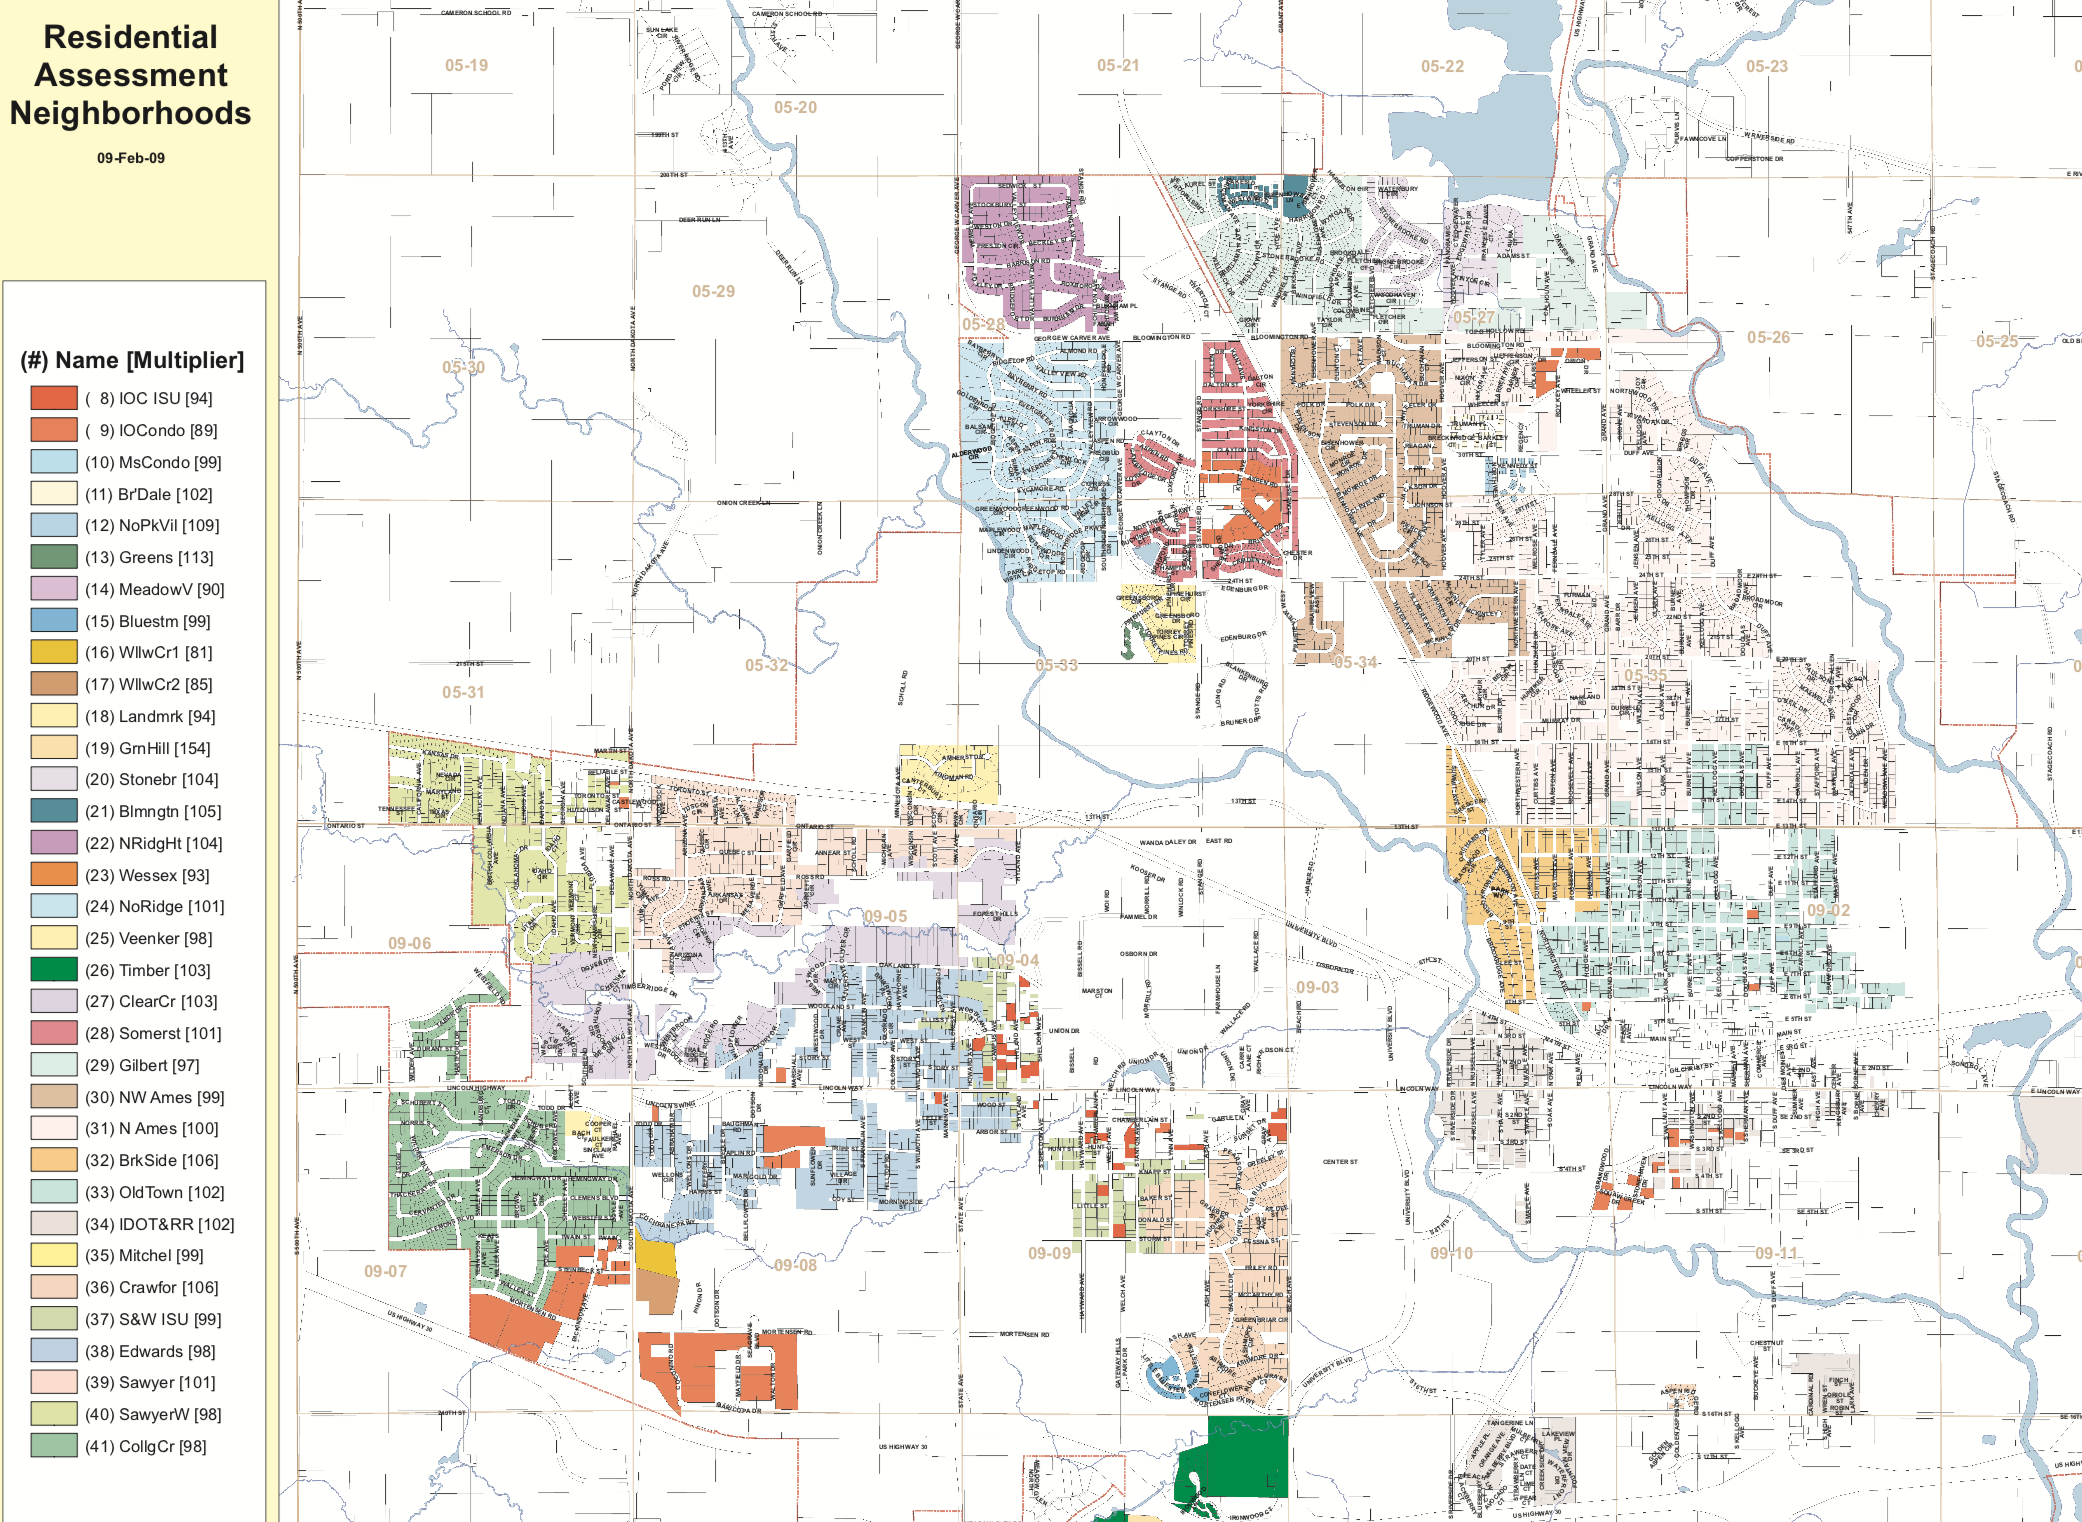

In [443]:
PATH = '/content/drive/My Drive/Projects/Machine Learning/Real World Problems/Housing Prices/house-prices-advanced-regression-techniques/nbor.png'
from PIL import Image  
Image.open(PATH)

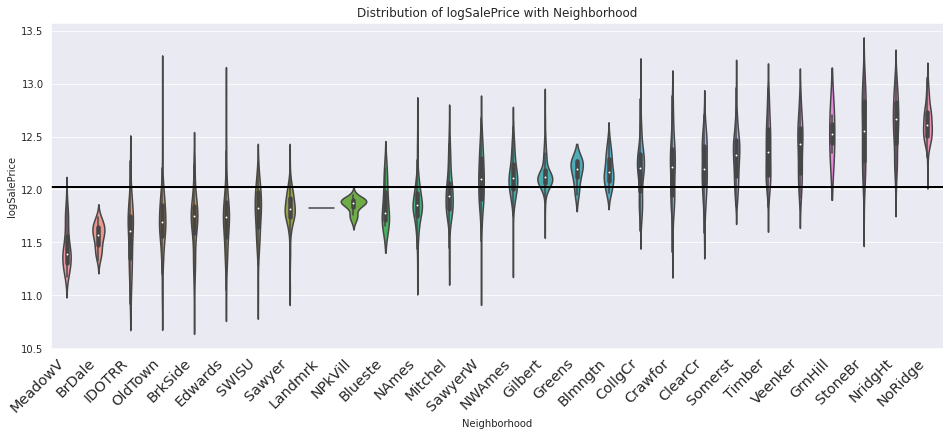

In [444]:
plt.rcParams["figure.figsize"] = (16,6)
CatPlot('Neighborhood')

* Sale Price is higher in Residential zones (more so in low density 'L') and floating villages (FV) and lower in Agricultural/Industrial zones.

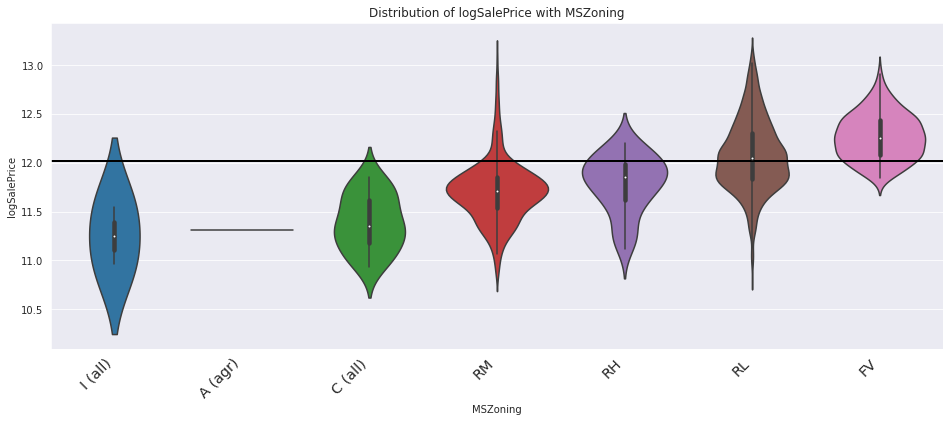

In [445]:
CatPlot('MSZoning')

* The Parcel Number can be used to pin down the exact location of the house. 

In [0]:
df.PID = df.PID.astype(str) # Parcel Identification
df['PID1']=df.PID.str[0:1] # township
df['PID2']=df.PID.str[1:3] # section number
df['PID3']=df.PID.str[3:6] # quarter section (N, E, S, W, etc)
df['PID4']=df.PID.str[6:10] # parcel number within section

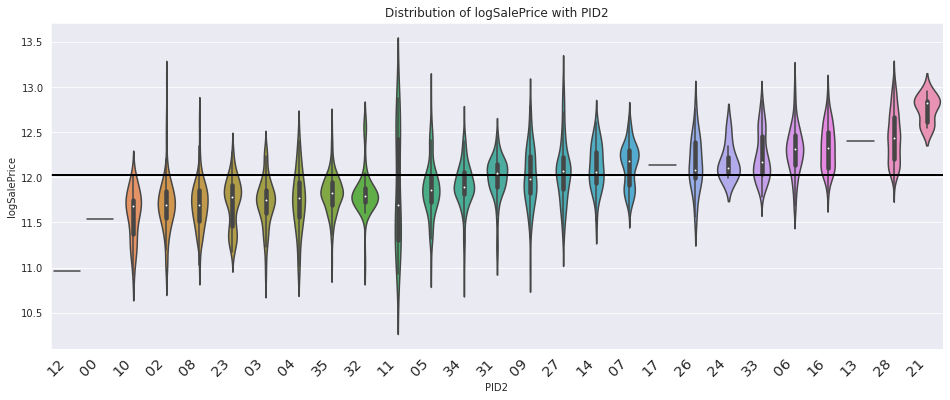

In [447]:
CatPlot('PID2')

* LOCATION is captured by Neighborhood, PID2 'Township-Sector' and Zone. 
* We can explain upto 60% of the variation in Sale Price
* However, LOCATION cannot tell explain extremely large variations in Sale Price

Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

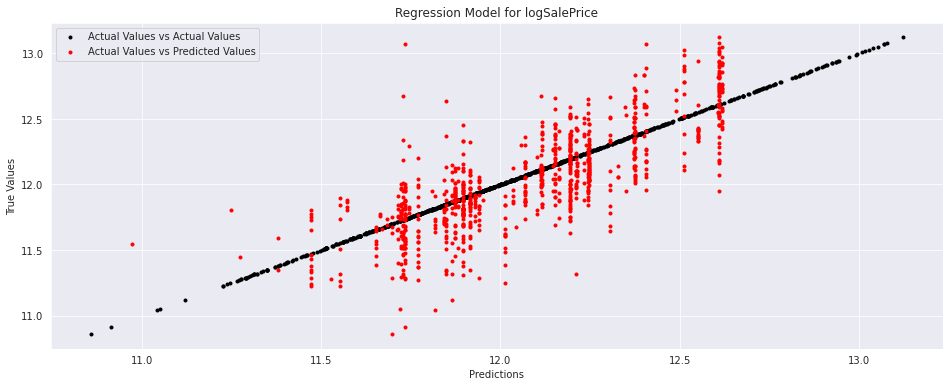

In [448]:
LOCATION = ['Neighborhood', 'PID2', 'MSZoning']
modelLOCATION = NNReg(LOCATION, yhat_and_y = True)

# **House Size & Area**
* While the house Lot Area (complete enclosure) is much larger, Prices depend more on the actual "Floor Area"/"Living Area". 
* Floor Area includes the Living spaces, enclosed Porchs, Garage, etc. And definitions vary. 
* After some trial and error: Floor Area = Basement + First & Second Floor + Garage Area 

In [0]:
df['PorchArea'] = df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch
df['FloorArea'] = df.TotalBsmtSF + df['1stFlrSF'] + df['2ndFlrSF'] + df['GarageArea']
AREA = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea',  'PoolArea', 'FloorArea', 'PorchArea']
df[AREA] = df[AREA].fillna(0)

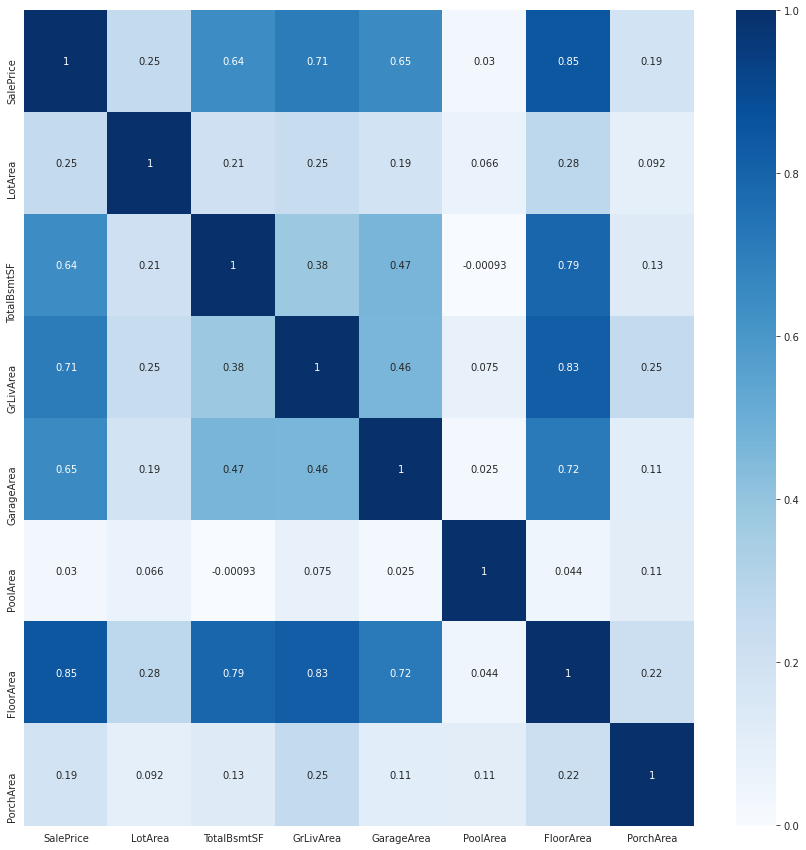

In [450]:
plt.figure(figsize=(15, 15))
sns.heatmap(df[['SalePrice']+ AREA].corr(), annot=True, cmap = 'Blues')
plt.show()

Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

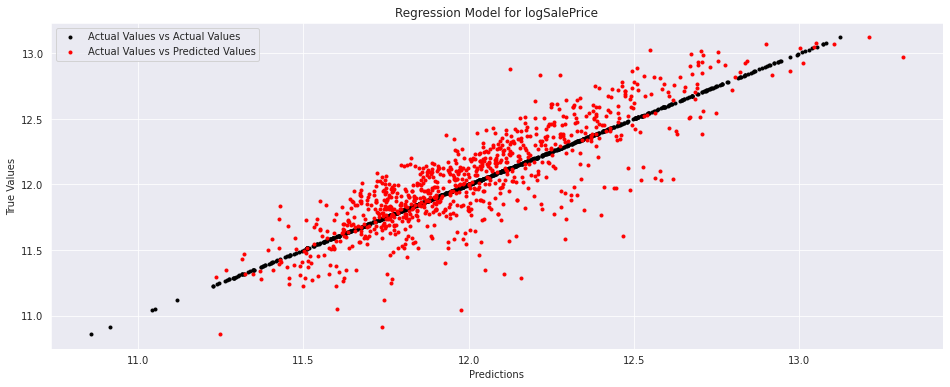

In [451]:
modelAREA = NNReg(AREA, alpha=10, yhat_and_y = True)

# **Subjective Evaluations**

In [452]:
SUBJ_EVAL = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'FireplaceQu', 'BsmtCond']
model_SUBJ_EVAL = NNReg(SUBJ_EVAL)

Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

# **House Build**

Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

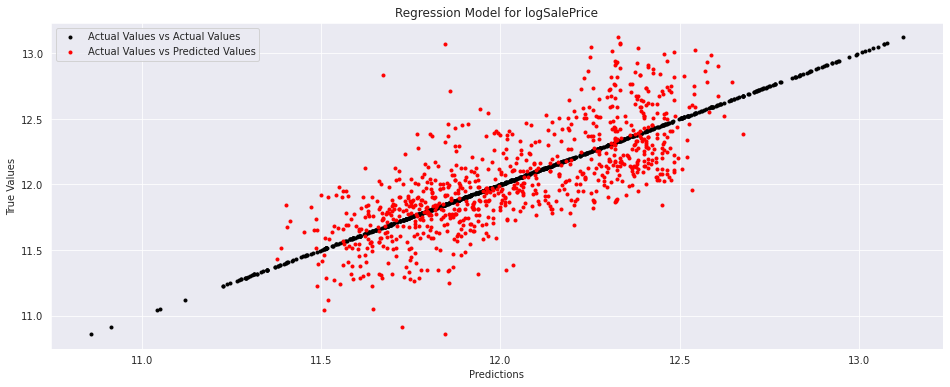

In [453]:
df['Age'] = df.YrSold - df.YearBuilt
df['AgeRemod'] = df['YrSold'] - df['YearRemod/Add']
BUILD = ['Age', 'MSSubClass', 'LandContour', 'LotConfig', 
         'LotShape', 'BldgType', 'HouseStyle', 'AgeRemod']

model_BUILD = NNReg(BUILD, yhat_and_y=True)

# **Context of Sale**
* Does not seem to have any significant effect. 
* For example, 

In [0]:
df['YrMoSold'] = df.YrSold.astype(str) + df.MoSold.astype(str) 
#df['YrMoSold'] = pd.to_datetime(df['YrMoSold'], format = 'yyyyMM')
#df = df.sort_values(by = 'YrMoSold')
#df[['SalePrice', 'YrMoSold']].groupby('YrMoSold').mean().plot()

In [455]:
CONTEXT = ['SaleType', 'SaleCondition', 'YrSold', 'MoSold']
model_CONTEXT = NNReg(CONTEXT)

Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

# **Common Model** 


Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

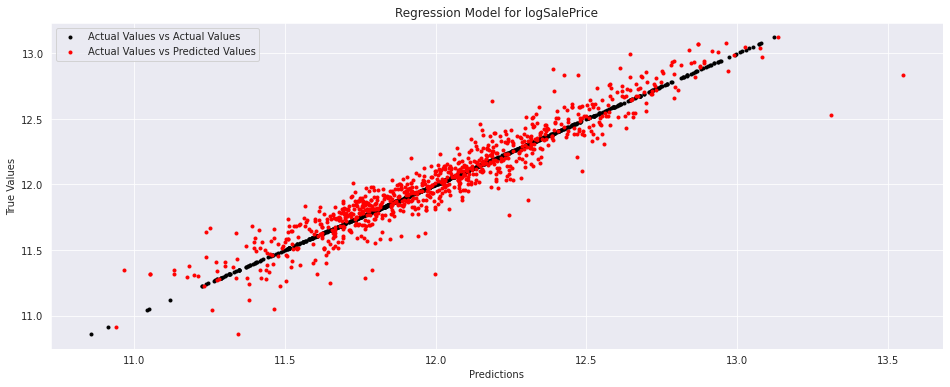

In [456]:
model_COMMON = NNReg(AREA + LOCATION + SUBJ_EVAL + BUILD + CONTEXT, yhat_and_y = True, alpha = 5)

# **Stacking Models**

In [457]:
x_train, x_val, y_train, y_val = DataGen(AREA)
yhatAREA = modelAREA.predict(x_train)

x_train, x_val, y_train, y_val = DataGen(LOCATION)
yhatLOCATION = modelLOCATION.predict(x_train)

x_train, x_val, y_train, y_val = DataGen(SUBJ_EVAL)
yhat_SUBJ_EVAL = model_SUBJ_EVAL.predict(x_train)

x_train, x_val, y_train, y_val = DataGen(BUILD)
yhat_BUILD = model_BUILD.predict(x_train)

x_train, x_val, y_train, y_val = DataGen(CONTEXT)
yhat_CONTEXT = model_CONTEXT.predict(x_train)


Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

* Predictions of Different Factors are Uncorrelated

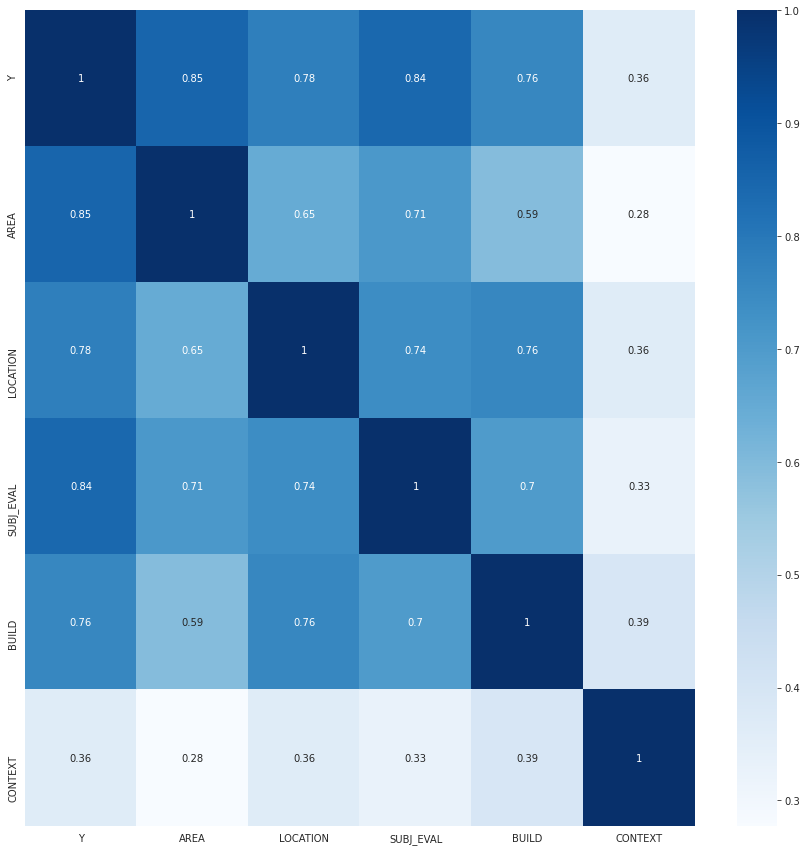

In [458]:
temp = pd.DataFrame(np.c_[y_train, yhatAREA, yhatLOCATION, yhat_SUBJ_EVAL, yhat_BUILD, yhat_CONTEXT], 
                    columns = ['Y', 'AREA', 'LOCATION', 'SUBJ_EVAL', 'BUILD', 'CONTEXT'])
plt.figure(figsize=(15, 15))
sns.heatmap(temp.corr(), annot=True, cmap = 'Blues')
plt.show()

In [459]:
x_train, x_val, y_train, y_val = train_test_split(temp.drop('Y', axis = 1), temp['Y'])
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(1521, 5) (507, 5) (1521,) (507,)


Each set of prediction is capturing a different aspect of true Y. Area features capture something that location feature do not. 

In [0]:
N_h, alpha = 200, 1
model = MLPRegressor(hidden_layer_sizes = (N_h, N_h/2), alpha = alpha, max_iter = 5000, random_state = 42, verbose = False)
#model.fit(x_train, y_train)
#yhat = model.predict(x_train)
#print(f'Train R Square: {r2_score(y_train, yhat):0.3f}')
#print(f'Test R Square: {r2_score(y_val, model.predict(x_val)):0.3f}')

#plt.figure(figsize=(16, 6))
#plt.scatter(y_val, y_val, c = 'black',  marker='.', label = 'Actual Values vs Actual Values')
#plt.scatter(model.predict(x_val), y_val, c = 'red', marker='.', label = 'Actual Values vs Predicted Values')
#plt.title('Regression Model for logSalePrice')
#plt.ylabel('True Values')
#plt.xlabel('Predictions')
#plt.legend()
#plt.show()